# **Importing Libraries**

In [1081]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as ss
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
from sklearn.impute import KNNImputer
from prophet import Prophet

# **Data Loading and Exploration**

In [1082]:
data = pd.read_csv('messy_dataset.csv')
data.head(5)

,DATE,BY PRODUCT,PROVINCE,DISTRICT ID,DISTRICT,STATION ID,STATION,MINIMUM,MAXIMUM
0,01/01/2019,Wheat,Punjab,NaN,NaN,NaN,Alipur,NaN,1305.0
1,01/01/2019,Wheat,Punjab,NaN,NaN,NaN,Chichawatni,1290.0,1305.0
2,01/01/2019,Wheat,Punjab,NaN,NaN,NaN,Pakpattan,1290.0,1305.0
3,01/01/2019,Wheat,Punjab,NaN,NaN,NaN,Arifwala,1300.0,NaN
4,01/01/2019,Wheat,Punjab,NaN,NaN,NaN,Bahawalnagar,1300.0,1315.0


In [1083]:
data.describe()

,DISTRICT ID,STATION ID,MINIMUM,MAXIMUM
count,31256.000000,31241.000000,27546.000000,27604.000000
mean,61.151764,322.969398,2103.436413,2130.978389
std,43.366499,212.858511,813.823882,832.594346
min,1.372910,8.000000,27.000000,1010.000000
25%,24.000000,157.000000,1380.000000,1410.000000
50%,72.000000,287.000000,2030.000000,2050.000000
75%,95.000000,526.000000,2575.000000,2600.000000
max,1150.000000,5910.000000,33700.000000,26250.000000


In [1084]:
data.isna().sum()

DATE            4197
BY PRODUCT      4190
PROVINCE        4160
DISTRICT ID    10650
DISTRICT       10645
STATION ID     10665
STATION         4192
MINIMUM        14360
MAXIMUM        14302
dtype: int64

In [1085]:
data.dtypes

DATE            object
BY PRODUCT      object
PROVINCE        object
DISTRICT ID    float64
DISTRICT        object
STATION ID     float64
STATION         object
MINIMUM        float64
MAXIMUM        float64
dtype: object

# **Data Cleaning**

## **KNN Imputation for MIN & MAX**

In [1086]:
knn_data = data[['MINIMUM', 'MAXIMUM']]

imputer = KNNImputer(n_neighbors=50)

knn_data_filled = imputer.fit_transform(knn_data)

knn_data_filled = pd.DataFrame(knn_data_filled, columns=['MINIMUM', 'MAXIMUM']).round(0).astype(int)

data[['MINIMUM', 'MAXIMUM']] = knn_data_filled

In [1087]:
data.isna().sum()

DATE            4197
BY PRODUCT      4190
PROVINCE        4160
DISTRICT ID    10650
DISTRICT       10645
STATION ID     10665
STATION         4192
MINIMUM            0
MAXIMUM            0
dtype: int64

## **DATE Interpolate**

In [1088]:
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

data.sort_values('DATE', inplace=True)

data['DATE'] = data['DATE'].interpolate()

print(data['DATE'].isna().sum())

0


## **All BY PRODUCT to Wheat**

In [1089]:
data['BY PRODUCT'] = 'Wheat'
print(data['BY PRODUCT'].isna().sum())

0


In [1090]:
data.isna().sum()

DATE               0
BY PRODUCT         0
PROVINCE        4160
DISTRICT ID    10650
DISTRICT       10645
STATION ID     10665
STATION         4192
MINIMUM            0
MAXIMUM            0
dtype: int64

In [1091]:
data['STATION'].nunique()

175

## **Mappings**

In [1092]:
station_mapping = {
  'IslamBbad': 'Islamabad',
  'rAifwala': 'Arifwala',
  'Mirpur khas': 'Mirpur Khas',
  'Rahimyar khan': 'Rahim Yar Khan',
  'yHderabad': 'Hyderabad',
  'thuddo': 'Jhuddo',
  'Jhudo': 'Jhuddo',
  'DZharki': 'Daharki',
  'Liaqauatpur': 'Liaqatpur',
  'Hsailpur': 'Hasilpur',
  'Kunri': 'Kunir',
  'Mehrab Pur': 'Mehrabpur',
  'BahYwalpur': 'Bahawalpur',
  'Chicahwatni': 'Chichawatni',
  'Dunga Bunga': 'Dunga Bunga',
  'DungaGBunga': 'Dunga Bunga',
  'Dunga Buxga': 'Dunga Bunga',
  'Sdaiqabad': 'Sadiqabad',
  'GUJRAT': 'Gujrat',
  'Bhaawalnagar': 'Bahawalnagar',
  'Haji Pur/': 'Haji Pur',
  'Dajal/Jam Pur': 'Dajal Jam Pur',
  'Ldohran': 'Lodhran',
  'Choti Zareen': 'Choti Zareen',
  'Dharya khan': 'Dharya Khan',
  'Taunsa sharif': 'Taunsa Sharif',
  'Shahar Sultan': 'Shaher Sultan',
  'Kahror Pacca': 'Karor Pakka',
  'Fazil Pur': 'Fazilpur',
  'Yazman Mandi': 'Yazman',
  'Nawab Shah': 'Nawabshah',
  'Shahpur Chakar': 'Shahpur Chakar',
  'Hasilpru': 'Hasilpur',
  'RanKpur': 'Ranipur',
  'Jatoi': 'Jatoi',
  'Qazi Ahmad': 'Qazi Ahmed',
  'Shahdadpur': 'Shahdadpur',
  'Khanewal': 'Khanewal',
  'Chowk Munda': 'Chowk Munda',
  'Mian Channu': 'Mian Channu',
  'Sahiwal': 'Sahiwal',
  'Chowk Azam': 'Chowk Azam',
  'Shorkot': 'Shorkot',
  'Nankana Sahib': 'Nankana Sahib',
  'Sheikhupura': 'Sheikhupura',
  'Pattoki': 'Pattoki',
  'Minchinabad': 'Minchinabad',
  'Kotri': 'Kotri',
  'Padidan': 'Padidan',
  'Muridke': 'Muridke',
  'Kamoki': 'Kamoki',
  'KhairBur': 'Khairpur',
  'Gujar Khan': 'Gujar Khan',
  'Depalpur': 'Depalpur',
  'Safdarabad': 'Safdarabad',
  'Dipalpur': 'Dipalpur',
  'Chiniot': 'Chiniot',
  'Salehput': 'Salehpat',
  'Tando Jan Mohammad': 'Tando Jan Muhammad',
  'Tando Adam Khan': 'Tando Adam',
  'Nauabad': 'Naukot',
  'Hala': 'Hala',
  'Fortabbas': 'Fort Abbas',
  'Piplan': 'Piplan',
  'Sujawal': 'Sujawal',
  'Faqirwali': 'Faqirwali',
  'Mehrabpur': 'Mehrabpur',
  'Golarchi Taluka': 'Golarchi',
  'Tando Muhammad Khan': 'Tando Muhammad',
  'Badah': 'Badah',
  'Bhan Sayedabad': 'Bhan Sayedabad',
  'Shahpur': 'Shahpur',
  'Samaro': 'Samaro',
  'Shikarpur': 'Shikarpur',
  'Mirpur Mathelo': 'Mirpur Mathelo',
  'Mailsi': 'Mailsi',
  'Fatehpur': 'Fatehpur',
  'Jampur': 'Jampur',
  'Dera Ghazi Khan': 'Dera Ghazi Khan',
  'Okara': 'Okara',
  'Marot': 'Marot',
  'Khipro': 'Khipro',
  'Head Bakkani': 'Head Bakkan',
}


In [1093]:
data['STATION'] = data['STATION'].replace(station_mapping)

In [1094]:
data['STATION'].nunique()

145

In [1095]:
data['DISTRICT'].nunique()

68

In [1096]:
district_mapping = {
  'Lfdhran': 'Lodhran',
  'Khaenwal': 'Khanewal',
  'Rahim Yra Khan': 'Rahim Yar Khan',
  'Sangahr': 'Sanghar',
  'Naushdo Feroze': 'Naushahro Feroze',
  'rhotki': 'Ghotki',
  'hGotki': 'Ghotki',
  'Hdyerabad': 'Hyderabad',
  'Bahawaplur': 'Bahawalpur',
  'Faisalabed': 'Faisalabad',
  'IPlamabad': 'Islamabad',
  'Badhn': 'Badin',
  'Rajan Pur': 'Rajanpur'
}


In [1097]:
data['DISTRICT'] = data['DISTRICT'].replace(district_mapping)

In [1098]:
data['DISTRICT'].nunique()

57

In [1099]:
data['PROVINCE'].nunique()

20

In [1100]:
province_mapping = {
  'Punjab': 'Punjab',
  'Sindh': 'Sindh',
  'SindI': 'Sindh',
  'Punjba': 'Punjab',
  'Siodh': 'Sindh',
  'PunjaS': 'Punjab',
  'Pnujab': 'Punjab',
  'Puejab': 'Punjab',
  'Pujnab': 'Punjab',
  'Pnnjab': 'Punjab',
  'Punjah': 'Punjab',
  'SinXh': 'Sindh',
  'PuYjab': 'Punjab',
  'SinGh': 'Sindh',
  'Punhab': 'Punjab',
  'iSndh': 'Sindh',
  'Nunjab': 'Punjab',
  'SindU': 'Sindh',
  'SindH': 'Sindh',
  'SindB': 'Sindh'
}


In [1101]:
data['PROVINCE'] = data['PROVINCE'].replace(province_mapping)

In [1102]:
data['PROVINCE'].nunique()

2

In [1103]:
# drop all rows where STATION and STATION ID are missing
data = data.dropna(subset=['STATION', 'STATION ID'])


In [1104]:
province_mapping_by_station_id = data.dropna(subset=['STATION ID', 'PROVINCE']).drop_duplicates('STATION ID').set_index('STATION ID')['PROVINCE']
district_id_mapping_by_station_id = data.dropna(subset=['STATION ID', 'DISTRICT ID']).drop_duplicates('STATION ID').set_index('STATION ID')['DISTRICT ID']
district_mapping_by_station_id = data.dropna(subset=['STATION ID', 'DISTRICT']).drop_duplicates('STATION ID').set_index('STATION ID')['DISTRICT']

province_mapping_by_station = data.dropna(subset=['STATION', 'PROVINCE']).drop_duplicates('STATION').set_index('STATION')['PROVINCE']
district_id_mapping_by_station = data.dropna(subset=['STATION', 'DISTRICT ID']).drop_duplicates('STATION').set_index('STATION')['DISTRICT ID']
district_mapping_by_station = data.dropna(subset=['STATION', 'DISTRICT']).drop_duplicates('STATION').set_index('STATION')['DISTRICT']

province_mapping_by_district_id = data.dropna(subset=['DISTRICT ID', 'PROVINCE']).drop_duplicates('DISTRICT ID').set_index('DISTRICT ID')['PROVINCE']
province_mapping_by_district = data.dropna(subset=['DISTRICT', 'PROVINCE']).drop_duplicates('DISTRICT').set_index('DISTRICT')['PROVINCE']

data['PROVINCE'] = data['PROVINCE'].fillna(data['STATION ID'].map(province_mapping_by_station_id))
data['DISTRICT ID'] = data['DISTRICT ID'].fillna(data['STATION ID'].map(district_id_mapping_by_station_id))
data['DISTRICT'] = data['DISTRICT'].fillna(data['STATION ID'].map(district_mapping_by_station_id))

data['PROVINCE'] = data['PROVINCE'].fillna(data['STATION'].map(province_mapping_by_station))
data['DISTRICT ID'] = data['DISTRICT ID'].fillna(data['STATION'].map(district_id_mapping_by_station))
data['DISTRICT'] = data['DISTRICT'].fillna(data['STATION'].map(district_mapping_by_station))

data['PROVINCE'] = data['PROVINCE'].fillna(data['DISTRICT ID'].map(province_mapping_by_district_id))
data['PROVINCE'] = data['PROVINCE'].fillna(data['DISTRICT'].map(province_mapping_by_district))

station_mapping_by_station_id = data.dropna(subset=['STATION ID', 'STATION']).drop_duplicates('STATION ID').set_index('STATION ID')['STATION']
station_id_mapping_by_station = data.dropna(subset=['STATION', 'STATION ID']).drop_duplicates('STATION').set_index('STATION')['STATION ID']

data['STATION'] = data['STATION'].fillna(data['STATION ID'].map(station_mapping_by_station_id))
data['STATION ID'] = data['STATION ID'].fillna(data['STATION'].map(station_id_mapping_by_station))

In [1105]:
data.isna().sum()

DATE           0
BY PRODUCT     0
PROVINCE       0
DISTRICT ID    0
DISTRICT       0
STATION ID     0
STATION        0
MINIMUM        0
MAXIMUM        0
dtype: int64

## **Duplicates**

In [1106]:
data.duplicated().sum()

3750

In [1107]:
data.drop_duplicates(inplace=True)

In [1108]:
data.dtypes

DATE           datetime64[ns]
BY PRODUCT             object
PROVINCE               object
DISTRICT ID           float64
DISTRICT               object
STATION ID            float64
STATION                object
MINIMUM                 int64
MAXIMUM                 int64
dtype: object

## **Outliers**

In [1109]:
# Function to detect outliers using IQR method
def detect_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
  return outliers

# Function to cap outliers using IQR method
def cap_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
  return df

# Detect outliers in MINIMUM and MAXIMUM columns
outliers_minimum = detect_outliers(data, 'MINIMUM')
outliers_maximum = detect_outliers(data, 'MAXIMUM')

# Print 2 rows of max outliers and min outliers before capping
print("Two rows of MAXIMUM outliers before capping:")
print(data[outliers_maximum].head(2))

print("\nTwo rows of MINIMUM outliers before capping:")
print(data[outliers_minimum].head(2))

# Cap outliers in MINIMUM and MAXIMUM columns
data = cap_outliers(data, 'MINIMUM')
data = cap_outliers(data, 'MAXIMUM')

Two rows of MAXIMUM outliers before capping:
           DATE BY PRODUCT PROVINCE  DISTRICT ID DISTRICT  STATION ID  \
2708 2020-03-02      Wheat   Punjab         11.0  Bhakkar        56.0   
2707 2020-03-02      Wheat    Sindh         41.0  Karachi       277.0   

      STATION  MINIMUM  MAXIMUM  
2708  Bhakkar     1480     1520  
2707  Karachi     1520     1520  

Two rows of MINIMUM outliers before capping:
           DATE BY PRODUCT PROVINCE  DISTRICT ID         DISTRICT  STATION ID  \
2711 2020-03-02      Wheat   Punjab         66.0  Mandi Bahauddin       379.0   
2708 2020-03-02      Wheat   Punjab         11.0          Bhakkar        56.0   

              STATION  MINIMUM  MAXIMUM  
2711  Mandi Bahauddin     1520     1600  
2708          Bhakkar     1480     1520  


# **EDA**

/var/folders/hq/f1f9rdc54j7957q7yl8hsy7r0000gn/T/ipykernel_74783/1394944108.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




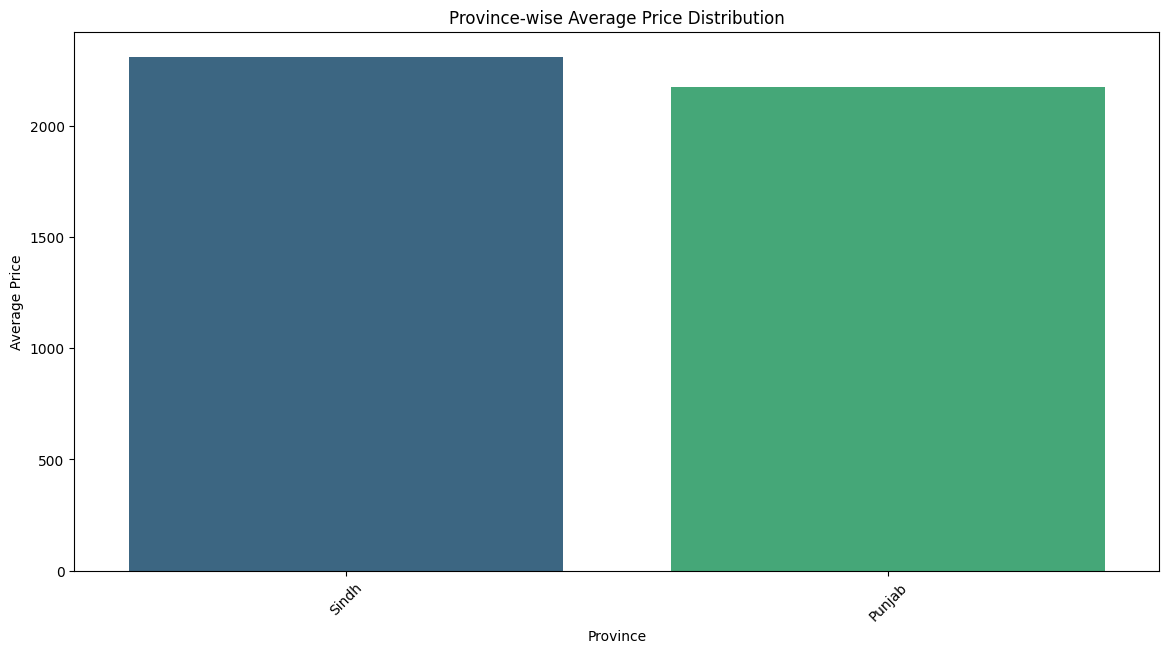

/var/folders/hq/f1f9rdc54j7957q7yl8hsy7r0000gn/T/ipykernel_74783/1394944108.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




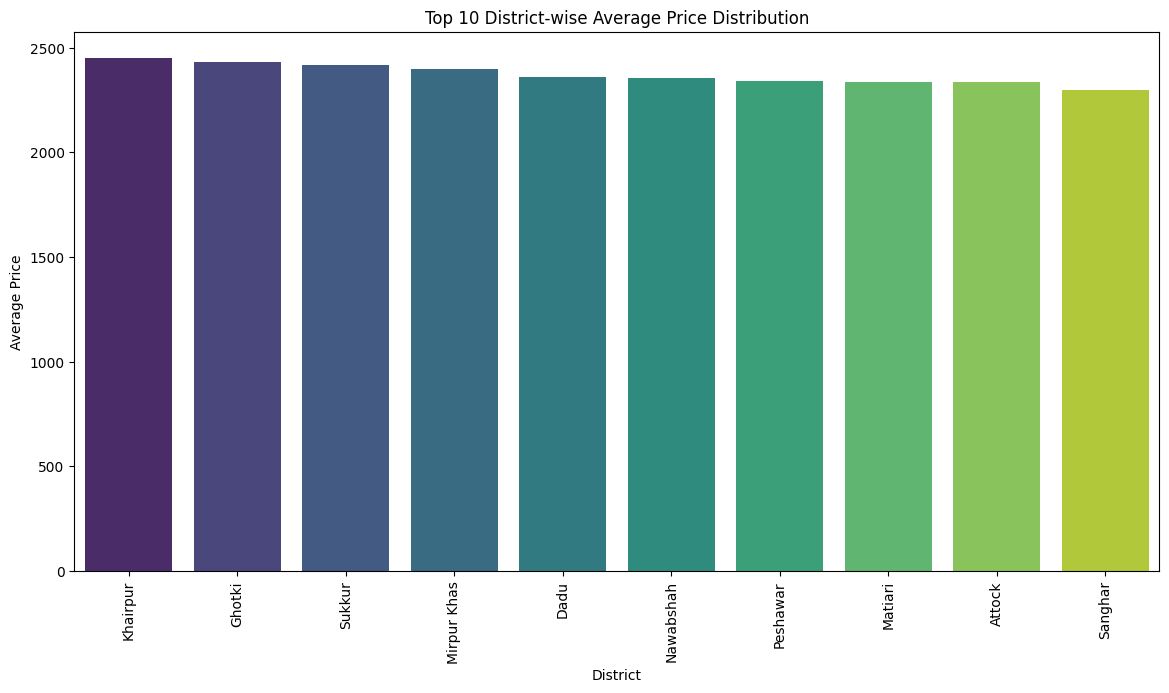

/var/folders/hq/f1f9rdc54j7957q7yl8hsy7r0000gn/T/ipykernel_74783/1394944108.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




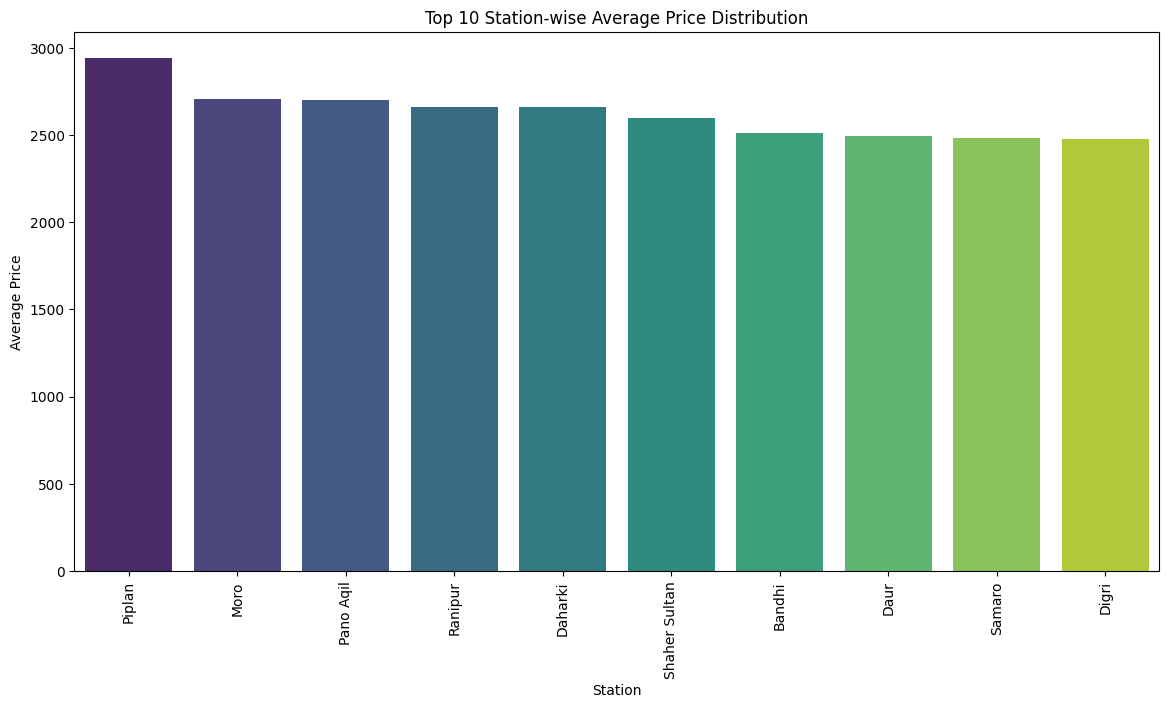

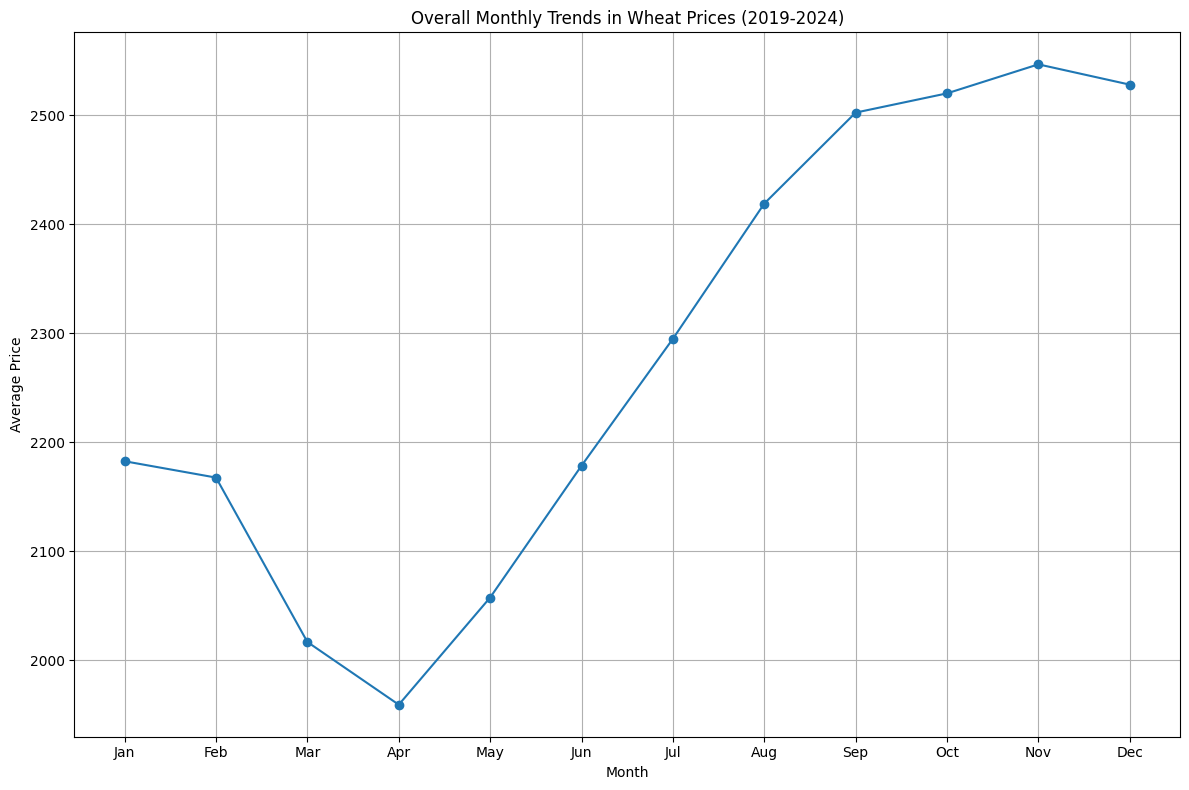

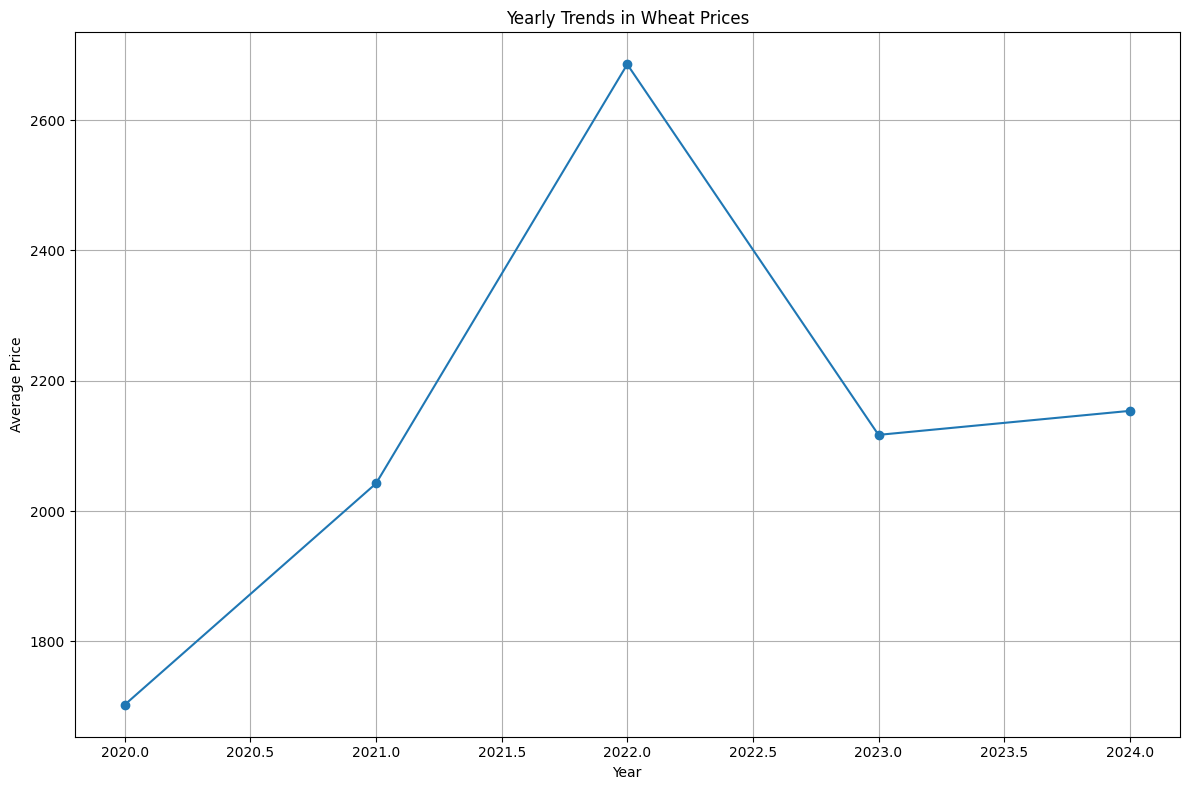

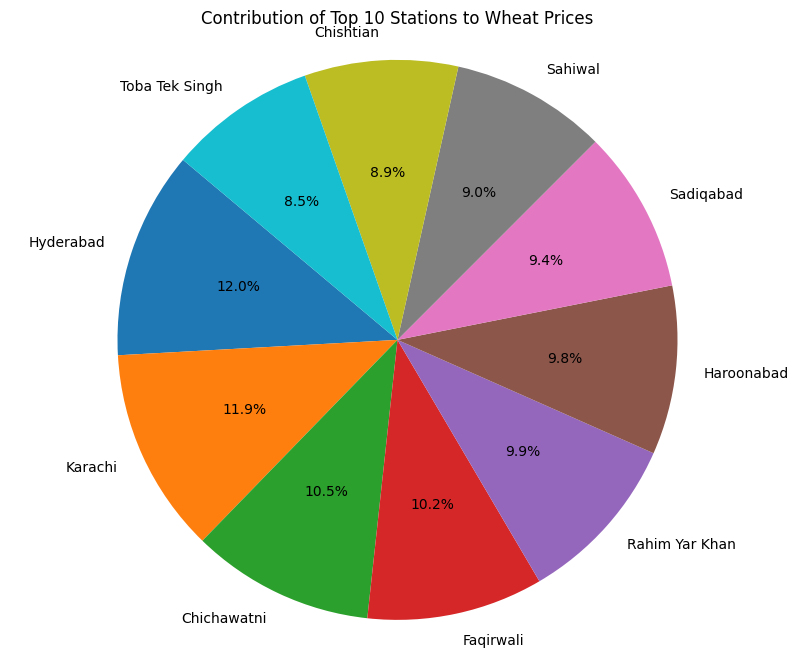

In [1110]:
# Calculate the average prices
data['AVERAGE_PRICE'] = data[['MINIMUM', 'MAXIMUM']].mean(axis=1)

# Top 10 Province-wise Average Price Distribution
province_avg = data.groupby('PROVINCE')['AVERAGE_PRICE'].mean().reset_index()
top10_provinces = province_avg.nlargest(10, 'AVERAGE_PRICE')

plt.figure(figsize=(14, 7))
sns.barplot(x='PROVINCE', y='AVERAGE_PRICE', data=top10_provinces, palette='viridis')
plt.title('Province-wise Average Price Distribution')
plt.xlabel('Province')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

# Top 10 District-wise Average Price Distribution
district_avg = data.groupby('DISTRICT')['AVERAGE_PRICE'].mean().reset_index()
top10_districts = district_avg.nlargest(10, 'AVERAGE_PRICE')

plt.figure(figsize=(14, 7))
sns.barplot(x='DISTRICT', y='AVERAGE_PRICE', data=top10_districts, palette='viridis')
plt.title('Top 10 District-wise Average Price Distribution')
plt.xlabel('District')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

# Top 10 Station-wise Average Price Distribution
station_avg = data.groupby('STATION')['AVERAGE_PRICE'].mean().reset_index()
top10_stations = station_avg.nlargest(10, 'AVERAGE_PRICE')

plt.figure(figsize=(14, 7))
sns.barplot(x='STATION', y='AVERAGE_PRICE', data=top10_stations, palette='viridis')
plt.title('Top 10 Station-wise Average Price Distribution')
plt.xlabel('Station')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

# Convert 'DATE' to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Group by month and calculate the mean average price across all years
monthly_avg_prices = data.groupby(data['DATE'].dt.month)['AVERAGE_PRICE'].mean()

# Plotting overall monthly trends in wheat prices (2019-2024)
plt.figure(figsize=(12, 8))
plt.plot(monthly_avg_prices.index, monthly_avg_prices.values, marker='o', linestyle='-')
plt.title('Overall Monthly Trends in Wheat Prices (2019-2024)')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Group by year and calculate the mean average price for each year
yearly_avg_prices = data.groupby(data['DATE'].dt.year)['AVERAGE_PRICE'].mean()

# Plotting yearly trends in wheat prices
plt.figure(figsize=(12, 8))
plt.plot(yearly_avg_prices.index, yearly_avg_prices.values, marker='o', linestyle='-')
plt.title('Yearly Trends in Wheat Prices')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Group by station and calculate total contribution (sum of AVERAGE_PRICE)
station_contributions = data.groupby('STATION')['AVERAGE_PRICE'].sum()

# Select top 10 stations with highest total contribution
top_10_stations = station_contributions.nlargest(10)

# Plotting pie chart for top 10 stations by contribution
plt.figure(figsize=(10, 8))
plt.pie(top_10_stations, labels=top_10_stations.index, autopct='%1.1f%%', startangle=140)
plt.title('Contribution of Top 10 Stations to Wheat Prices')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [1111]:
for col in ['BY PRODUCT', 'PROVINCE', 'DISTRICT', 'STATION']:
  data[col] = data[col].astype('category')

data['DATE'] = pd.to_datetime(data['DATE'])
data['DISTRICT ID'] = data['DISTRICT ID'].astype(int)
data['STATION ID'] = data['STATION ID'].astype(int)
data['MINIMUM'] = data['MINIMUM'].astype(int)
data['MAXIMUM'] = data['MAXIMUM'].astype(int)

data.dtypes

DATE             datetime64[ns]
BY PRODUCT             category
PROVINCE               category
DISTRICT ID               int64
DISTRICT               category
STATION ID                int64
STATION                category
MINIMUM                   int64
MAXIMUM                   int64
AVERAGE_PRICE           float64
dtype: object

In [1112]:
data.describe()

,DATE,DISTRICT ID,STATION ID,MINIMUM,MAXIMUM,AVERAGE_PRICE
count,24356,24356.000000,24356.000000,24356.000000,24356.000000,24356.000000
mean,2022-07-26 17:05:39.957299712,60.919240,321.566226,2218.447939,2244.142265,2231.347183
min,2020-03-02 00:00:00,2.000000,8.000000,1525.000000,1532.000000,1528.750000
25%,2021-07-13 00:00:00,23.000000,154.000000,2050.000000,2068.000000,2057.500000
50%,2022-08-11 00:00:00,72.000000,287.000000,2103.000000,2131.000000,2117.000000
75%,2023-07-18 00:00:00,95.000000,526.000000,2400.000000,2425.000000,2413.000000
max,2024-06-22 00:00:00,1150.000000,5910.000000,2925.000000,2960.000000,2942.750000
std,NaN,43.835089,213.614115,402.545096,406.369474,404.086274


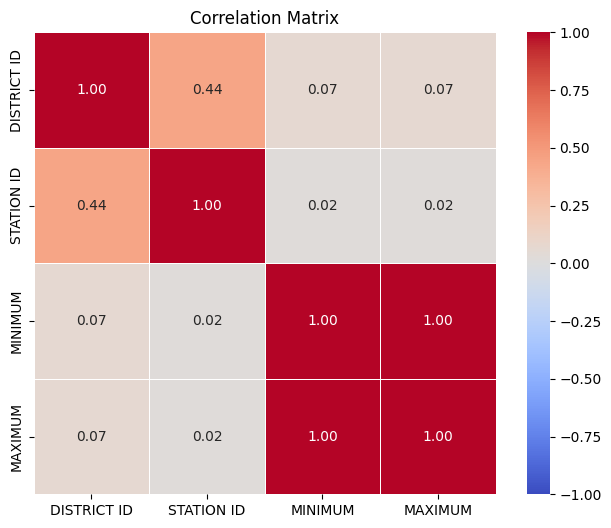

In [1113]:
# Compute correlation matrix
# Select numerical columns for correlation matrix
numerical_columns = ['DISTRICT ID', 'STATION ID', 'MINIMUM', 'MAXIMUM']
correlation_matrix = data[numerical_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# **Time Series Analysis**

In [1114]:
def forecast_feature(data, feature):
  future_dates = pd.date_range(start='2023-01-01', end='2024-05-31', freq='D')
  predictions = pd.DataFrame()

  for station in data['STATION'].cat.categories:
    df = data[data['STATION'] == station]
    if len(df) < 2:
      continue  # Skip stations with insufficient data
    
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
    df_prophet = df[['DATE', feature]].rename(columns={'DATE': 'ds', feature: 'y'})
    model.fit(df_prophet)
    
    future = pd.DataFrame(future_dates, columns=['ds'])
    forecast = model.predict(future)[['ds', 'yhat']]
    forecast['STATION'] = station
    forecast.rename(columns={'yhat': f'Predicted_{feature}'}, inplace=True)
    predictions = pd.concat([predictions, forecast], ignore_index=True)
  
  return predictions


In [1115]:
# Forecast MINIMUM and MAXIMUM
predicted_min = forecast_feature(data, 'MINIMUM')
predicted_max = forecast_feature(data, 'MAXIMUM')

# Merge predictions back into the main dataframe
data = data.merge(predicted_min, how='left', left_on=['DATE', 'STATION'], right_on=['ds', 'STATION'])
data = data.merge(predicted_max, how='left', left_on=['DATE', 'STATION'], right_on=['ds', 'STATION'])

# Clean up after merging
data.drop(columns=['ds_x', 'ds_y', 'AVERAGE_PRICE'], inplace=True, errors='ignore')

# Filter the final dataset to include only the predicted period and save
final_data = data[(data['DATE'] >= '2023-01-01') & (data['DATE'] <= '2024-05-31')]
# round off the predicted prices
final_data['Predicted_MINIMUM'] = final_data['Predicted_MINIMUM'].round(0)
final_data['Predicted_MAXIMUM'] = final_data['Predicted_MAXIMUM'].round(0)
final_data.to_csv('Predicted_Prices_2023_2024.csv', index=False)

print(final_data.head())

11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
11:44:02 - cmdstanpy - INFO - Chain [1] start processing
11:44:02 - cmdstanpy - INFO - Chain [1] done processing
11:44:02 - cmdstanpy - INFO - Chain [1] start processing
11:44:02 - cmdstanpy - INFO - Chain [1] done processing
11:44:02 - cmdstanpy - INFO - Chain [1] start processing
11:44:02 - cmdstanpy - INFO - Chain [1] done processing
11:44:02 - cmdstanpy - INFO - Chain [1] start processing
11:44:02 - cmdstanpy - INFO - Chain [1]

            DATE BY PRODUCT PROVINCE  DISTRICT ID     DISTRICT  STATION ID  \
15489 2023-01-02      Wheat    Sindh           45     Khairpur         292   
15490 2023-01-02      Wheat    Sindh           72  Mirpur Khas         410   
15491 2023-01-02      Wheat    Sindh          105       Sukkur         467   
15492 2023-01-02      Wheat    Sindh           24       Ghotki         184   
15493 2023-01-02      Wheat    Sindh            4        Badin          26   

           STATION  MINIMUM  MAXIMUM  Predicted_MINIMUM  Predicted_MAXIMUM  
15489     Khairpur     2103     2131             2445.0             2475.0  
15490  Mirpur Khas     2103     2131             2425.0             2454.0  
15491    Pano Aqil     2103     2131             2409.0             2439.0  
15492       Ghotki     2103     2131             2404.0             2434.0  
15493        Badin     2103     2131             2376.0             2400.0  


/var/folders/hq/f1f9rdc54j7957q7yl8hsy7r0000gn/T/ipykernel_74783/4249545074.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1116]:
# print 10 rows from 2nd Jan 2023

print(final_data[final_data['DATE'] == '2023-01-02'].head(10))

            DATE BY PRODUCT PROVINCE  DISTRICT ID     DISTRICT  STATION ID  \
15489 2023-01-02      Wheat    Sindh           45     Khairpur         292   
15490 2023-01-02      Wheat    Sindh           72  Mirpur Khas         410   
15491 2023-01-02      Wheat    Sindh          105       Sukkur         467   
15492 2023-01-02      Wheat    Sindh           24       Ghotki         184   
15493 2023-01-02      Wheat    Sindh            4        Badin          26   
15494 2023-01-02      Wheat    Sindh           72  Mirpur Khas         249   
15495 2023-01-02      Wheat    Sindh          113      Umarkot         344   
15496 2023-01-02      Wheat    Sindh           72  Mirpur Khas         535   
15497 2023-01-02      Wheat    Sindh            4        Badin         607   
15498 2023-01-02      Wheat    Sindh           72  Mirpur Khas         136   

           STATION  MINIMUM  MAXIMUM  Predicted_MINIMUM  Predicted_MAXIMUM  
15489     Khairpur     2103     2131             2445.0         